In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

In [25]:

file_medical = Path("Medical00_22.csv")
file_cpi = Path("CPI_Average.csv")

In [26]:


medical_file = pd.read_csv(file_medical)
CPI_file = pd.read_csv(file_cpi)

In [27]:


df_medical = pd.DataFrame(medical_file)
df_medical.set_index(pd.to_datetime(df_medical['Year'], infer_datetime_format=True), inplace=True)
df_medical = df_medical.drop(columns=['Year'], axis=1)
df_medical = df_medical.pct_change()


df_cpi = pd.DataFrame(CPI_file)
df_cpi.set_index(pd.to_datetime(df_cpi['Year'], infer_datetime_format=True), inplace=True) 
df_cpi = df_cpi.drop(columns=['Year'], axis=1)
df_cpi  = df_cpi.pct_change()


In [28]:
df_inflation = pd.concat([df_medical, df_cpi], axis="columns", join = "inner")

In [29]:
def fill_missing(values):
    one_month = 30
    for row in range(df_inflation.shape[0]):
        for col in range(df_inflation.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_month,col]
df_inflation = df_inflation.astype('float32')
fill_missing(df_inflation.values)
df_inflation.isnull().sum()

Medical    0
CPI        0
dtype: int64

In [30]:
daily_df = df_inflation.resample('Y').sum()
daily_df.head()

,Medical,CPI
Year,,
2000-12-31,0.036587,0.033395
2001-12-31,0.046151,0.015477
2002-12-31,0.048510,0.023544
2003-12-31,0.034452,0.018700
2004-12-31,0.040672,0.032135


In [31]:
def window_data(df_inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_inflation) - window):
        features = df_inflation.iloc[i : (i + window), feature_col_number]
        target = df_inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [32]:
 # Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_inflation, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")


X sample values:
[[ 0.00297089  0.00592417  0.00824499  0.00058411  0.00116754  0.00524781
   0.00232019  0.          0.00520833  0.00172712  0.00057471 -0.00057438
   0.00632184  0.00399772  0.00227531  0.00397276  0.00452233  0.00168824
  -0.00280899  0.          0.00450704 -0.00336512 -0.00168824 -0.00394589
   0.00226372  0.00395257  0.0056243   0.00559284  0.          0.00055617]
 [ 0.00592417  0.00824499  0.00058411  0.00116754  0.00524781  0.00232019
   0.          0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184
   0.00399772  0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899
   0.          0.00450704 -0.00336512 -0.00168824 -0.00394589  0.00226372
   0.00395257  0.0056243   0.00559284  0.          0.00055617  0.00111173]
 [ 0.00824499  0.00058411  0.00116754  0.00524781  0.00232019  0.
   0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184  0.00399772
   0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899  0.
   0.00450704 -0.00336512 -0.001688

In [33]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [35]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.70518863]
  [0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]]

 [[0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]
  [0.6459286 ]]

 [[0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777

In [36]:
model = Sequential()

# Initial model setup
number_units = 800
#hidden_units = 17 
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [37]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 800)           2566400   
                                                                 
 dropout_4 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_5 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_6 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_7 (LSTM)               (None, 800)              

In [39]:
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=100, verbose=1)

Epoch 1/100
2/2 [==============================] - 4s 62ms/step - loss: 0.3066
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 0.6402
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0583
Epoch 4/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0466
Epoch 5/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0576
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0811
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0385
Epoch 8/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0320
Epoch 9/100
2/2 [==============================] - 0s 61ms/step - loss: 0.0374
Epoch 10/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0221
Epoch 11/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0272
Epoch 12/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0219
Epoch 13/100
2/2 [==============================]

In [40]:
model.evaluate(X_test, y_test, verbose=0)

0.0140025420114398

In [41]:
predicted = model.predict(X_test)

3/3 [==============================] - 1s 38ms/step


In [42]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [43]:
# Create a DataFrame of Real and Predicted values
CPI = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_inflation.index[-len(real_prices): ]) 

# Show the DataFrame's head
CPI.tail()

,Actual,Predicted
Year,,
2022-01-01,0.008415,0.000777
2022-02-01,0.009134,0.001740
2022-03-01,0.013351,0.002785
2022-04-01,0.005583,0.003612
2022-05-01,0.011024,0.003887


<AxesSubplot:title={'center':'Actual Vs. Predicted'}, xlabel='Year'>

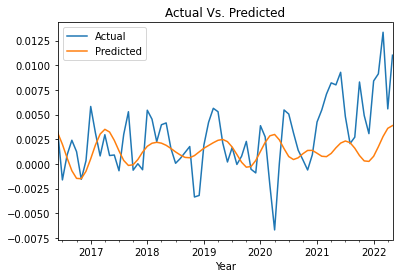

In [44]:
CPI.plot(title="Actual Vs. Predicted")

In [45]:
CPI.to_csv('medical.csv')